In [1]:
import pandas as pd

/nfs/home/jsewall/local/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": False,     # use inline math for ticks
    "font.size" : 12,
    "pgf.rcfonts": False,    # don't setup fonts from rc parameters
})

In [4]:
import numpy as np

In [5]:
def ordered_intersect(ordered, tokeep):
    res = []
    s = frozenset(tokeep)
    for v in ordered:
        if v in s:
            res.append(v)
    return res

In [6]:
app_colors = {
    "openmp": "#FE6100",
    "onedpl": "#785EF0",
    "raja": "#DC267F",
    "kokkos": "#648FFF",
    "sycl": "#FFB000",
}
app_name_map = {
    "openmp": "OpenMP",
    "kokkos-sycl" : "Kokkos (SYCL)",
    "omp-target": "OpenMP (target)",
    "onedpl": "oneDPL",
    "raja": "Raja",
    "kokkos": "Kokkos",
    "sycl": "SYCL",
}
app_order = ['openmp',  'kokkos', 'raja', 'sycl', 'onedpl']

subapp_map = {
    'openmp' : 'openmp',
    'omp-target' : 'openmp',
    'kokkos' : 'kokkos',
    'kokkos-sycl' : 'kokkos',
    'raja' : 'raja',
    'sycl' : 'sycl',
    'onedpl' : 'onedpl',
}

In [7]:
platform_name_map = {
    'clx' : "2 x Intel® Xeon® Gold 6230",
    'clx_1S' : "1 x Intel® Xeon® Gold 6230",
    'a100' : "NVIDIA A100",
    'mi100' : "AMD MI100",
    'rome_cce' : '2 x AMD EPYC 7742',
    'rome_aocc' : '2 x AMD EPYC 7742',
    'gen9' : 'Intel® Iris® Pro 580'
}

In [8]:
kernel_name_map = {
   'dot' : 'Dot',
   'field_summary' : 'Field Summary',
    'complex_sum' : 'Complex Sum',
   'complex_sum_soa' : 'Complex Sum (SoA)',
    'complex_min' : 'Complex Min',
    'describe' : 'Describe'    
}
kernel_order = ['dot', 'complex_sum', 'complex_sum_soa', 'complex_min', 'describe', 'field_summary']

In [9]:
# Create a DataFrame of the mean value of the runs for each kernel, for each model, for one architecture
def average(arch):
    return data.loc[data['arch'] == arch].groupby(['kernel','model'], as_index=False).mean()

# Create a DataFrame of the minimum value of the runs for each kernel, for each model, for one architecture
def lower(arch):
    return data.loc[data['arch'] == arch].groupby(['kernel','model'], as_index=False).min()

# Create a DataFrame of the maximum value of the runs for each kernel, for each model, for one architecture
def upper(arch):
    return data.loc[data['arch'] == arch].groupby(['kernel','model'], as_index=False).max()

# Create a DataFrame of the mean value of the runs for each kernel for one architecture/compiler combination
def average_c(arch, compiler):
    return data.loc[(data['arch'] == arch) & (data['compiler'] == compiler)].groupby(['kernel','model'], as_index=False).mean()

# Plot a grouped bar chart of mean value of each kernel in each model for a given architecture
def plot(name, vals):
    vals['model'] = vals['model'].map(lambda x: subapp_map[x])
    kernels = ordered_intersect(kernel_order, vals['kernel'].unique())
    apps = ordered_intersect(app_order, [j for j in vals['model'].unique()])
    fig = plt.figure(figsize=(6,5.5))
    ax = fig.add_subplot()
    x = dict(zip(kernel_order,np.arange(len(kernel_order))))
    
    width = 0.8/len(app_order)
    ax.set_xlim([0-width*(len(app_order)-1)/1, len(kernel_order)-1+width*(len(app_order)-1)/1])
    for i, app in enumerate(app_order):
        if app not in apps:
            continue
        q = vals.loc[vals['model'] == app]
        offs = (i - (len(app_order)-1)/2.0)*width
        k = [x[j] + offs for j in q['kernel']]
        y = q['bandwidth']*100
        ax.bar(k, y, width=width, color=app_colors[app], label=app_name_map[app])
    plt.xlabel('Kernel')
    plt.ylabel('Efficiency in %')
    plt.grid(axis='y')
   
    locs, labels = plt.xticks()   
    labels = [kernel_name_map[k] for k in kernel_order]
    plt.xticks(np.arange(len(kernel_order)),labels)
    labels = ax.get_xticklabels()
    ax.set_xticklabels(labels, rotation=25, ha='right', rotation_mode='anchor')
    plt.title(platform_name_map[name])
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    lgd=ax.legend(loc='upper left', bbox_to_anchor=(1.0, 0.7), handlelength=1.0)
    fig.savefig(f'{name}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

In [10]:
#These are in GB/s, normalized to 1 socket/GPU 
arch_peaks = pd.read_csv("./peaks.csv", skipinitialspace=True)
arch_peaks = pd.Series(arch_peaks.bandwidth.values, index=arch_peaks.arch).to_dict()
arch_peaks


{'a100': 2039.0,
 'mi100': 1228.8,
 'EPYC 7742': 204.8,
 'Xeon 6230': 241.0,
 'Core 6770HQ': 34.1}

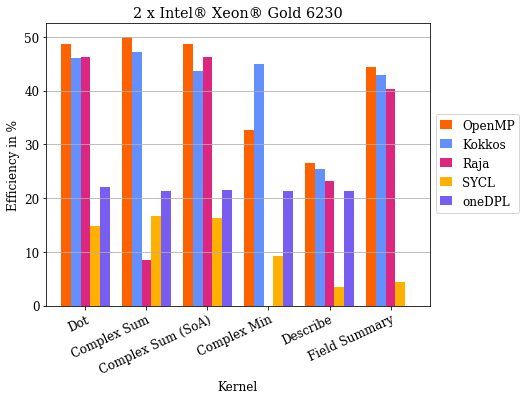

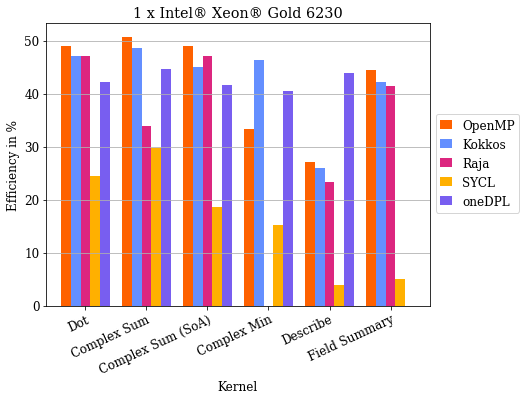

In [11]:
data = pd.read_csv("./clx-results.csv", skipinitialspace=True)
vals = average('clx')
vals['bandwidth'] /= arch_peaks['Xeon 6230']*2
plot('clx', vals)
data = pd.read_csv("./clx-1S-results.csv", skipinitialspace=True)
vals = average('clx_1S')
vals['bandwidth'] /= arch_peaks['Xeon 6230']
plot('clx_1S', vals)

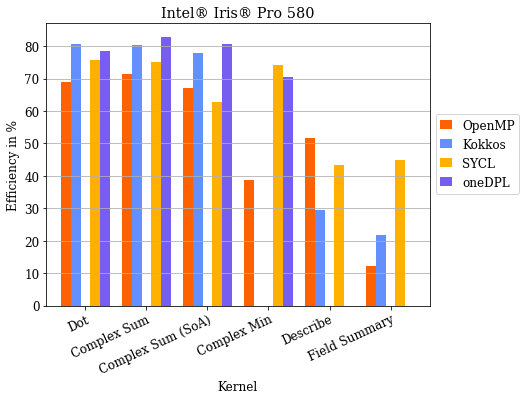

In [12]:
data = pd.read_csv("./gen9-results.csv", skipinitialspace=True)
vals = average('gen9')
vals['bandwidth'] /= arch_peaks['Core 6770HQ']
plot('gen9', vals)

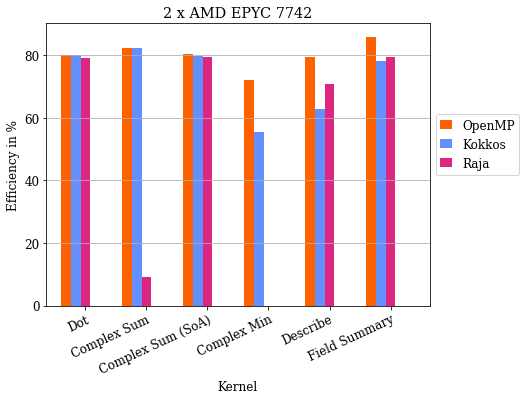

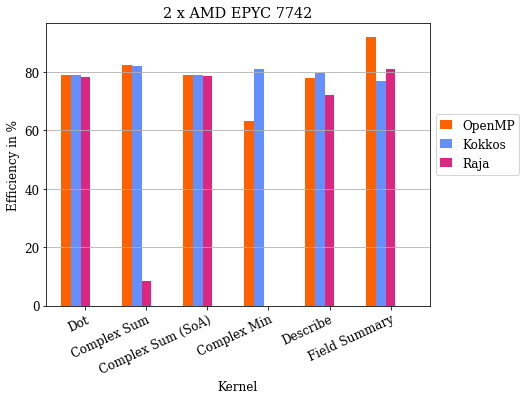

In [13]:
data = pd.read_csv("./rome-results-cce.csv", skipinitialspace=True)
vals = average_c('rome', 'cce')
vals['bandwidth'] /= arch_peaks['EPYC 7742']*2
plot('rome_cce', vals)
data = pd.read_csv("./rome-results-aocc.csv", skipinitialspace=True)
vals = average_c('rome', 'aocc')
vals['bandwidth'] /= arch_peaks['EPYC 7742']*2
plot('rome_aocc', vals)

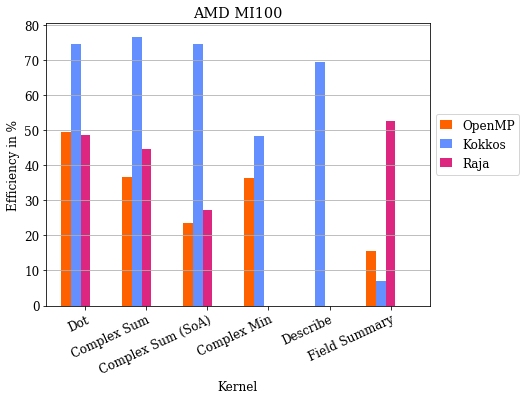

In [14]:
data = pd.read_csv("./mi100-results.csv", skipinitialspace=True)
vals = average('mi100')
vals['bandwidth'] /= arch_peaks['mi100']
plot('mi100', vals)

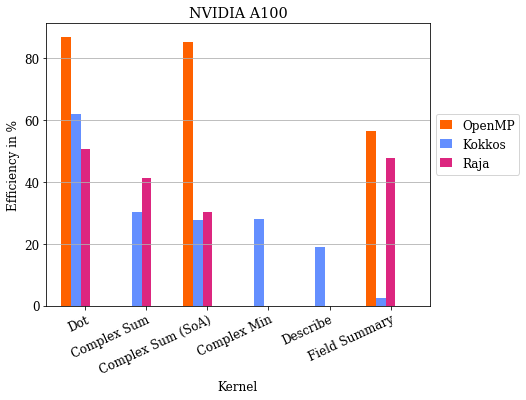

In [15]:
data = pd.read_csv("./a100-results.csv", skipinitialspace=True)
vals = average('a100')
vals['bandwidth'] /= arch_peaks['a100']
plot('a100', vals)